# Titanic Dataset

In [39]:
import pandas as pd
import numpy as np
from pandas import DataFrame

## Preprocessing

In [40]:
data = DataFrame.from_csv("./titanic/train.csv")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can directly save the survived column as our labels

In [41]:
y = data["Survived"].as_matrix()

### Non-informative features

Next, we can drop the label and all non-informative from the feature matrix

In [42]:
X = data.drop(["Survived", "Name", "Ticket", "Cabin"], 1)

### One-hot encoding

Many features are categorical, and not ordinal, e.g. `Pclass` or `Embarked`. We need to encode these features using a one-hot encoding.

In [43]:
X = pd.get_dummies(X)

In [44]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
2,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
3,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
4,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
5,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


### Missing values

Unfortunately, the age of some passengers is unknown. We will need to impute these missing values for sklearn. For our own implementation this might not be necessary.

In [45]:
X.isnull().any()

Pclass        False
Age            True
SibSp         False
Parch         False
Fare          False
Sex_female    False
Sex_male      False
Embarked_C    False
Embarked_Q    False
Embarked_S    False
dtype: bool

In [46]:
X[X.isnull().any(axis=1)].head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
6,3,NaN,0,0,8.4583,0.0,1.0,0.0,1.0,0.0
18,2,NaN,0,0,13.0000,0.0,1.0,0.0,0.0,1.0
20,3,NaN,0,0,7.2250,1.0,0.0,1.0,0.0,0.0
27,3,NaN,0,0,7.2250,0.0,1.0,1.0,0.0,0.0
29,3,NaN,0,0,7.8792,1.0,0.0,0.0,1.0,0.0


`sklearn` already has some helpers for dealing with missing values. For now we will just impute the mean value. This works because only `age` has missing values, which is an ordinal feature.

In [47]:
from sklearn.preprocessing import Imputer

imputer = Imputer()
X = imputer.fit_transform(X.as_matrix())

### Putting it together for Kaggle

Finally, we can create a simple function that does all of this, which will be useful for our test set. There is no `y_test` because Kaggle doesn't give out labels.

In [48]:
def preprocess(data):    
    X = data.drop(["Name", "Ticket", "Cabin"], 1)
    X = pd.get_dummies(X)
    X = imputer.transform(X)
    
    return X

In [49]:
data_test = DataFrame.from_csv("./titanic/test.csv")

In [50]:
X_test = preprocess(data_test)

## Training a decision tree

### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [64]:
clf.score(X_train, y_train)

0.9606741573033708

In [65]:
clf.score(X_test, y_test)

0.81005586592178769

In [66]:
clf.max_depth

### Individual decision tree

In [67]:
from sklearn import tree

In [68]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [69]:
clf.score(X_train, y_train)

0.9803370786516854

In [70]:
clf.score(X_test, y_test)

0.78212290502793291

#### Visualizing it

This requires graphviz to be installed, e.g. using `brew install graphviz`.

In [109]:
tree.export_graphviz(clf, out_file='tree.dot')

In [110]:
! dot -Tpng tree.dot -o tree.png

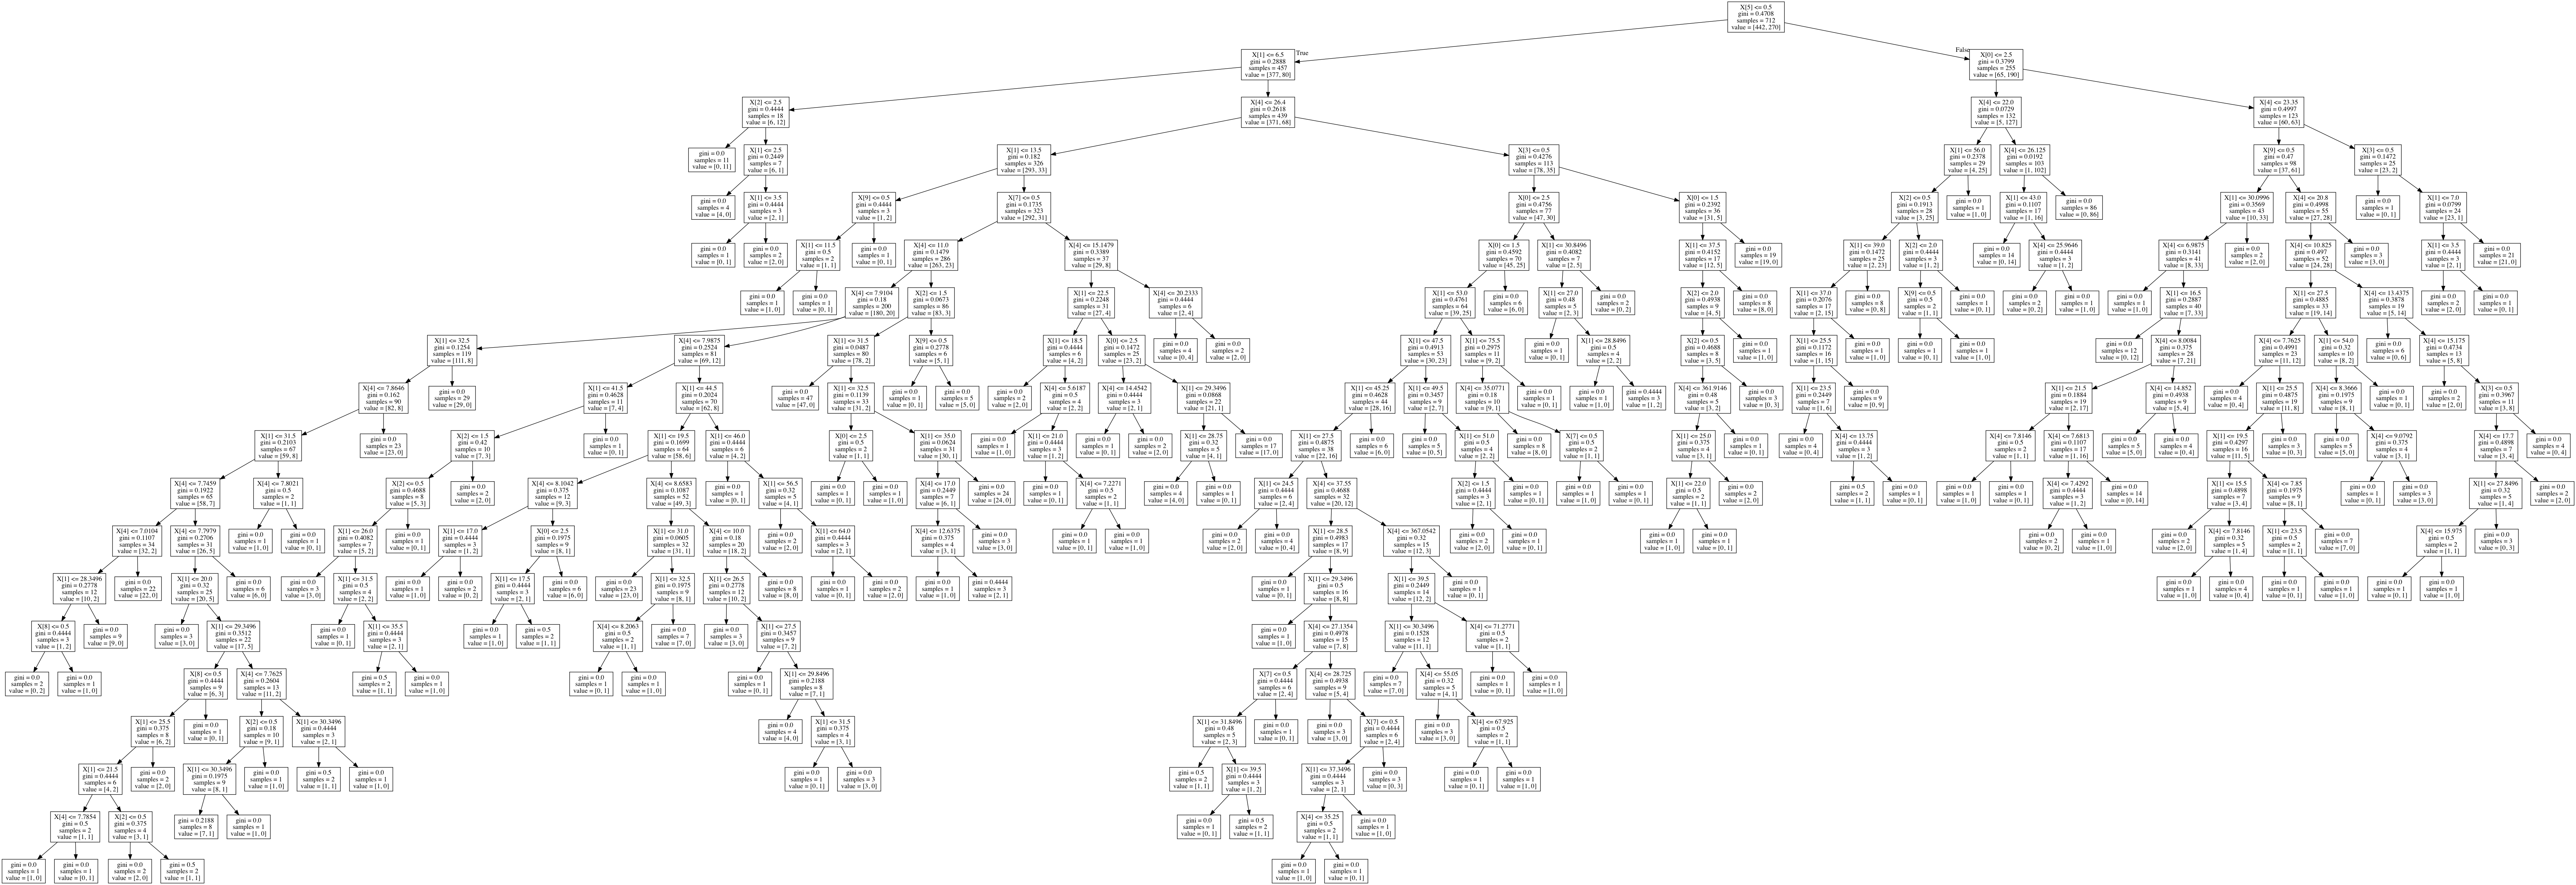

In [111]:
from IPython.display import Image
Image("tree.png")

## Further analysis

There are several duplicate rows:

In [32]:
len(set([tuple(row) for row in X]))

764

In [33]:
X.shape

(891, 10)

In [38]:
lst = [1,2,3, 2]
max(set(lst), key=lst.count)

2